In [45]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import shap
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

## Read data

In [ ]:
df = pd.read_csv("./temp/WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.dropna(how= "any", axis="index", inplace=True)
ind = df.loc[:,"EmployeeNumber"]
df.drop(columns="EmployeeNumber", inplace=True)

## Create the dependent variable

In [ ]:
y = df.loc[:, "Attrition"]
df.drop(columns ="Attrition", inplace=True)
y.loc[y == "Yes"] = 1
y.loc[y == "No"] = 0
y = y.astype(int)
y

C:\Users\ipkov\AppData\Local\Temp\ipykernel_2024\809797731.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y == "Yes"] = 1
C:\Users\ipkov\AppData\Local\Temp\ipykernel_2024\809797731.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y == "No"] = 0


0       1
1       0
2       1
3       0
4       0
       ..
1465    0
1466    0
1467    0
1468    0
1469    0
Name: Attrition, Length: 1470, dtype: int64

## Correlation (EDA)

<Axes: >

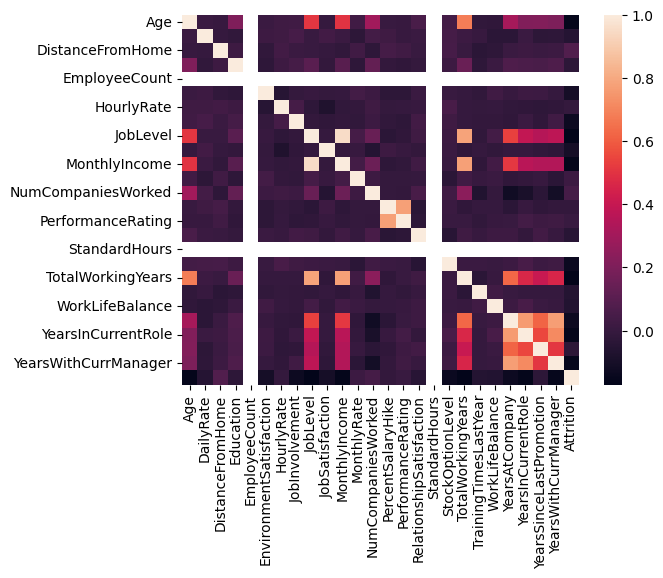

In [34]:
sns.heatmap(pd.concat((df.loc[:, df.dtypes == int], y), axis="columns").corr())

## Set data to category type

In [ ]:
### Data specific preprocessing.


ind = df.dtypes == "object"
names = [i for i in ind.index if ind[i]]
for i in names:
    df[i] = df[i].astype("category")


In [36]:
### Train-test split to make sure gridsearch finds the best model
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
813,39,Travel_Frequently,203,Research & Development,2,3,Life Sciences,1,1,Male,...,4,80,3,21,4,3,18,7,11,5
1226,32,Travel_Frequently,585,Research & Development,10,3,Life Sciences,1,1,Male,...,1,80,1,10,3,2,5,2,1,3
1285,46,Non-Travel,849,Sales,26,2,Life Sciences,1,2,Male,...,3,80,0,6,3,3,2,2,2,2
992,39,Non-Travel,1485,Research & Development,25,2,Life Sciences,1,3,Male,...,2,80,1,13,2,3,6,4,0,5
953,44,Travel_Rarely,935,Research & Development,3,3,Life Sciences,1,1,Male,...,3,80,0,10,4,4,3,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021,25,Travel_Rarely,383,Sales,9,2,Life Sciences,1,1,Male,...,1,80,0,6,2,3,3,2,2,2
1299,40,Travel_Rarely,1194,Research & Development,1,3,Life Sciences,1,3,Female,...,4,80,1,12,3,3,5,3,0,3
598,28,Travel_Rarely,890,Research & Development,2,4,Medical,1,3,Male,...,4,80,0,5,3,2,2,2,2,1
394,31,Travel_Rarely,480,Research & Development,7,2,Medical,1,2,Female,...,2,80,1,13,5,1,13,10,3,12


## Train model with GridSearchCV

In [37]:
### Train a simple decision tree
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}
clf = GridSearchCV(estimator=xgb.XGBClassifier(enable_categorical=True), 
                           param_grid=param_grid, 
                           cv=5,  # 5-fold cross-validation
                           scoring='accuracy')
clf.fit(X_train, y_train)
model = clf.best_estimator_
print(f"Accuracy: {clf.best_score_}" )


Accuracy: 0.8733032816444284


In [38]:
### Check on test data...
y_hat = model.predict(X_test)
accuracy_score(y_test, y_hat)

0.8877551020408163

## Shapley figures - contribution of variables to Attrition

In [39]:
### Shap for checking the contribution of features
exp = shap.TreeExplainer(model)
explainer = exp(X) 

### Summary plot
- Positive shapley value influences towards attrition
- Grey values are categorical value
- Colors show feature value, x-axis shows the contribution towards attrition
- Features are ordered per importance
- This only describes the model...
- Also shows distribution of the shapley values

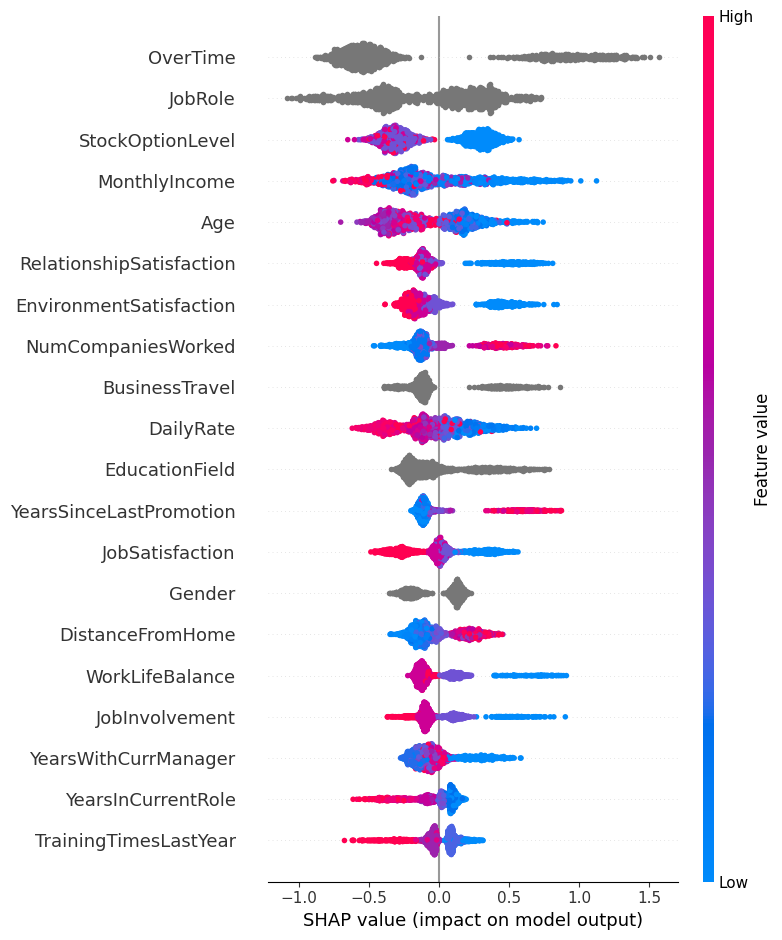

In [ ]:
shap.summary_plot(explainer, X)


### Waterfall plot
- Shows the shapley values for individuals
- Shows how the shapley value affects the output variable


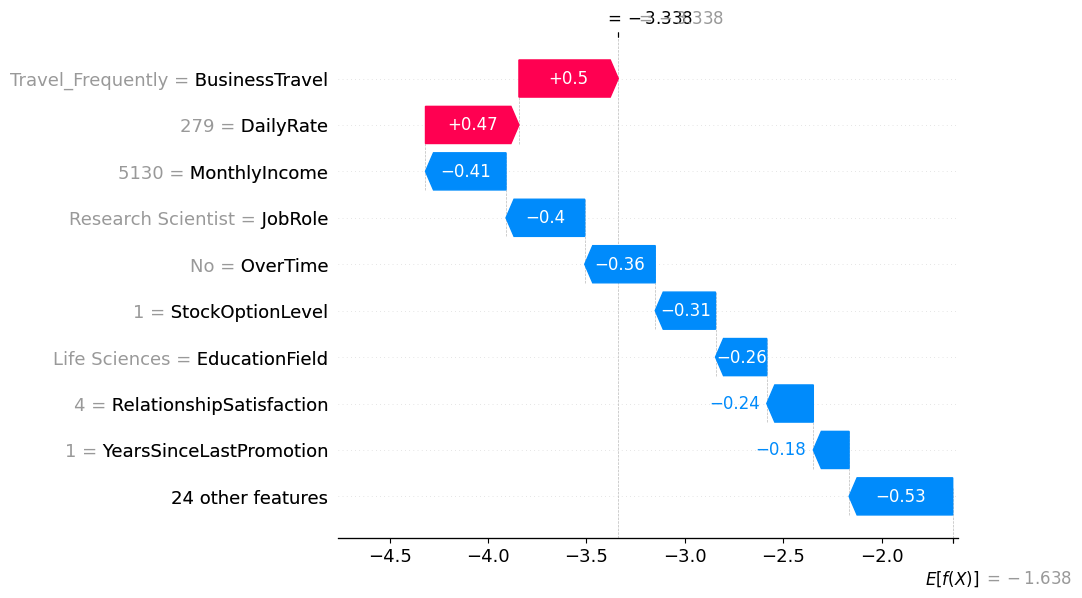

In [40]:
shap.plots.waterfall(explainer[1])

### Barplot

- Shows the importance of a variable by taking the mean of the absolute shapley value
- Relative value


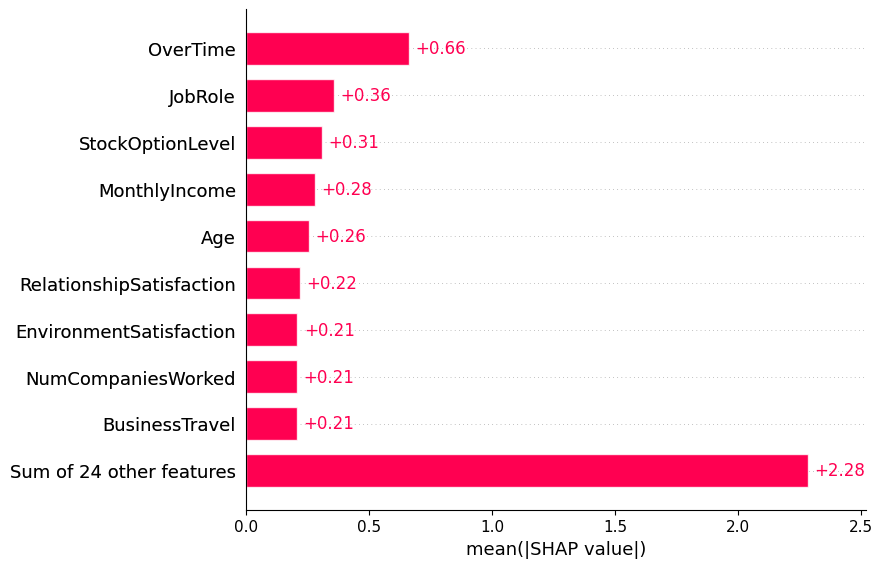

In [44]:
##Waterfall plor for a employee.
shap.plots.bar(explainer)

https://medium.com/biased-algorithms/shap-values-for-classification-4aa3b4aeb87c